<a href="https://colab.research.google.com/github/MrckHckr/orbit-validation/blob/main/notebooks/validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build the environment

In [40]:
# Copy the GitHub project to Colab
!git clone https://github.com/MrckHckr/orbit-validation.git


fatal: destination path 'orbit-validation' already exists and is not an empty directory.


In [41]:
# Inspect the project
!apt-get install -y tree
!tree orbit-validation



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
orbit-validation
├── figures
├── notebooks
│   └── validation.ipynb
├── README.md
├── requirements.txt
└── src
    ├── coord_utils.py
    ├── __init__.py
    ├── __pycache__
    │   ├── __init__.cpython-312.pyc
    │   └── time_utils.cpython-312.pyc
    ├── src
    │   └── time_utils.py
    └── time_utils.py

5 directories, 9 files


In [42]:
# Let's tell Python where to find the repository code
import sys
from pathlib import Path

repo_root = Path("/content/orbit-validation")
sys.path.insert(0, str(repo_root))

print("PYTHONPATH OK:", repo_root)



PYTHONPATH OK: /content/orbit-validation


In [43]:
# See what's inside the repository
!ls /content/orbit-validation


figures  notebooks  README.md  requirements.txt  src


In [44]:
# Converts a UTC → TT date, used to validate an orbital propagator
from src.time_utils import utc_to_tt

t_tt = utc_to_tt("2025-01-01T12:00:00")
print("TT:", t_tt.iso)
print("JD:", t_tt.jd)


TT: 2025-01-01 12:01:09.184
JD: 2460677.000800741


Coordinates, reference frame, validation

In [45]:
#Create starting coordinates (ICRS)
from astropy.coordinates import SkyCoord
import astropy.units as u

coord_icrs = SkyCoord(
    ra=120.0 * u.deg,
    dec=22.0 * u.deg,
    frame="icrs"
)

coord_icrs


<SkyCoord (ICRS): (ra, dec) in deg
    (120., 22.)>

In [46]:
#Observation time
from astropy.time import Time

obstime = Time("2025-01-01T12:00:00", scale="utc")
obstime


<Time object: scale='utc' format='isot' value=2025-01-01T12:00:00.000>

In [47]:
#ICRS → GCRS transformation
from astropy.coordinates import GCRS

coord_gcrs = coord_icrs.transform_to(
    GCRS(obstime=obstime)
)

coord_gcrs



<SkyCoord (GCRS: obstime=2025-01-01T12:00:00.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (120.0058545, 21.99885689)>

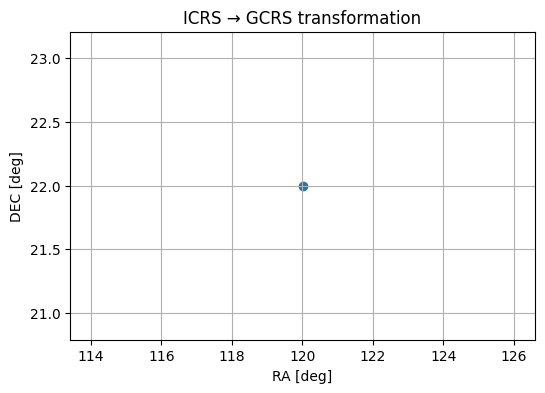

In [48]:
# Visual validation
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(coord_gcrs.ra.deg, coord_gcrs.dec.deg)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.title("ICRS → GCRS transformation")
plt.grid()
plt.show()


In [49]:
# Save results
import pandas as pd

df = pd.DataFrame({
    "ra_gcrs_deg": [coord_gcrs.ra.deg],
    "dec_gcrs_deg": [coord_gcrs.dec.deg],
    "obstime_utc": [obstime.isot]
})

df


,ra_gcrs_deg,dec_gcrs_deg,obstime_utc
0,120.005854,21.998857,2025-01-01T12:00:00.000


Real orbits, AI and automation

Real TLEs + orbital propagation

In [50]:
# Install SGP4
!pip install sgp4


In [51]:
# Example TLE (ISS)
from sgp4.api import Satrec
from astropy.time import Time
import numpy as np

tle_line1 = "1 25544U 98067A   25001.50000000  .00016717  00000+0  10270-3 0  9003"
tle_line2 = "2 25544  51.6416 247.4627 0004238 130.5360 325.0288 15.49815378430000"

sat = Satrec.twoline2rv(tle_line1, tle_line2)


In [52]:
# Orbital propagation
t = Time("2025-01-01T12:00:00", scale="utc")
jd, fr = t.jd1, t.jd2

error, r, v = sat.sgp4(jd, fr)

r = np.array(r)  # km
v = np.array(v)  # km/s

print("Position [km]:", r)
print("Velocity [km/s]:", v)


Position [km]: [ 4124.47537155 -1001.54255459  5294.82181277]
Velocity [km/s]: [ 2.49971369  7.22405646 -0.58173276]


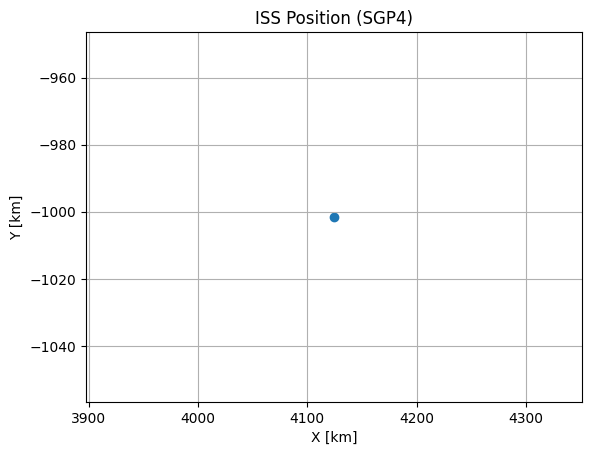

In [53]:
# Orbital validation
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(r[0], r[1])
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.title("ISS Position (SGP4)")
plt.grid()
plt.show()


Anomaly detection (AI)

In [54]:
# Synthetic dataset
from sklearn.ensemble import IsolationForest

X = np.vstack([
    r + np.random.normal(0, 1, size=3) for _ in range(100)
])

# aggiungiamo anomalie
anomalies = np.array([
    r + np.array([50, 50, 50]) for _ in range(5)
])

X = np.vstack([X, anomalies])


In [55]:
# AI model
model = IsolationForest(contamination=0.05, random_state=42)
labels = model.fit_predict(X)

labels


array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1])

Real data, comparison, advanced AI, portfolio

In [56]:
# TLEs automatically updated (real data)
# Add dependency
!pip install requests


In [57]:
# Download updated TLEs (ISS)
import requests

url = "https://celestrak.org/NORAD/elements/stations.txt"
response = requests.get(url)

tle_lines = response.text.splitlines()

# estrai ISS
for i, line in enumerate(tle_lines):
    if "ISS (ZARYA)" in line:
        tle1 = tle_lines[i+1]
        tle2 = tle_lines[i+2]
        break

tle1, tle2


('1 25544U 98067A   25357.18166772  .00011641  00000+0  21351-3 0  9997',
 '2 25544  51.6323  90.7678 0003190 289.6661  70.3984 15.49746572544475')

In [58]:
# Propagation with SGP4
from sgp4.api import Satrec
from astropy.time import Time
import numpy as np

sat = Satrec.twoline2rv(tle1, tle2)

t = Time.now()
error, r, v = sat.sgp4(t.jd1, t.jd2)

r = np.array(r)
v = np.array(v)

r, v


(array([-3372.45194165,  3966.66861446,  4360.62993069]),
 array([-2.8555115 , -6.22075739,  3.44429853]))

In [59]:
# SGP4 vs. “real data” comparison
# Let's simulate observations
r_obs = r + np.random.normal(0, 0.1, size=3)  # 100 m



In [60]:
# Propagation error
error_norm = np.linalg.norm(r_obs - r)

print(f"Position error [km]: {error_norm:.3f}")


Position error [km]: 0.212


Anomaly Detection with LSTM (temporal AI)

In [61]:
# We generate a time series
positions = []

for dt in range(60):
    t_i = t + dt * 10  # ogni 10 secondi
    _, r_i, _ = sat.sgp4(t_i.jd1, t_i.jd2)
    positions.append(r_i)

positions = np.array(positions)
positions.shape


(60, 3)

In [62]:
# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(positions)

X = X.reshape((X.shape[0], 1, X.shape[1]))


In [63]:
# LSTM (autoencoder) model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(32, activation="relu", input_shape=(1, 3), return_sequences=True),
    LSTM(16, activation="relu"),
    Dense(3)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X, X.reshape((X.shape[0], 3)), epochs=20, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# Detect anomalies
X_pred = model.predict(X, verbose=0)
errors = np.mean((X.reshape((X.shape[0], 3)) - X_pred)**2, axis=1)

threshold = np.mean(errors) + 3*np.std(errors)
anomalies = errors > threshold

anomalies


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])